# Natural Language Processing with Disaster Tweets

In [1]:
import datetime
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer

np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
print(f"Starting this notebook at:{datetime.datetime.now()}")

Starting this notebook at:2023-08-14 13:15:07.741615


## Data

In [5]:
# Download data
!wget https://github.com/JSini/NLP_with_disaster_tweets/archive/refs/heads/main.zip

--2023-08-14 16:39:03--  https://github.com/JSini/NLP_with_disaster_tweets/archive/refs/heads/main.zip
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/JSini/NLP_with_disaster_tweets/zip/refs/heads/main [following]
--2023-08-14 16:39:03--  https://codeload.github.com/JSini/NLP_with_disaster_tweets/zip/refs/heads/main
Resolving codeload.github.com (codeload.github.com)... 140.82.112.10
Connecting to codeload.github.com (codeload.github.com)|140.82.112.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘main.zip’

main.zip                [ <=>                ] 806.41K  --.-KB/s    in 0.1s    

2023-08-14 16:39:03 (8.00 MB/s) - ‘main.zip’ saved [825760]



In [6]:
# extract the train and test csv files from the main.zip

import zipfile

local = 'main.zip'

zipref = zipfile.ZipFile(local)
zipref.extractall()
zipref.close()

In [7]:
## get the train and test data into DataFrames

train_df = pd.read_csv('/content/NLP_with_disaster_tweets-main/train.csv')
test_df = pd.read_csv('/content/NLP_with_disaster_tweets-main/test.csv')

In [8]:
## shapes
train_df.shape, test_df.shape

((7613, 5), (3263, 4))

In [9]:
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [10]:
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


Observe that the test data has got  no target data. This dataset has been sourced from Kaggle competetion. To evaluate on test data, we can submit our work to kagle and get the score.

In [11]:
## Summary about the train data
train_df.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Columns: 5 entries, id to target
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [12]:
## detailed info about all columns
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [13]:
# lets look at the target counts in train data
train_df.target.value_counts()

0    4342
1    3271
Name: target, dtype: int64

kind of balanced

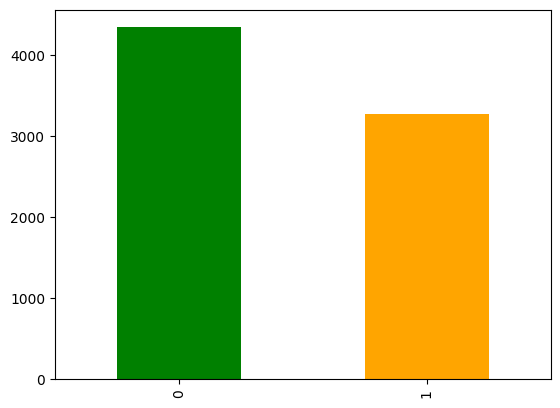

In [14]:
# visualize the counts
train_df.target.value_counts().plot(kind='bar', color=['green', 'orange']);

**location**

In [15]:
train_df.location.value_counts()

USA                    104
New York                71
United States           50
London                  45
Canada                  29
                      ... 
MontrÌ©al, QuÌ©bec       1
Montreal                 1
ÌÏT: 6.4682,3.18287      1
Live4Heed??              1
Lincoln                  1
Name: location, Length: 3341, dtype: int64

3341 different locations

In [16]:
test_df.location.value_counts()

New York                  38
USA                       37
Worldwide                 16
United States             15
London                    13
                          ..
Medford, NJ                1
Quezon City                1
LanÌ¼s                     1
USA,Washington,Seattle     1
Brussels, Belgium          1
Name: location, Length: 1602, dtype: int64

1602 locations

**keyword**:

In [17]:
train_df.keyword.value_counts()

fatalities               45
deluge                   42
armageddon               42
sinking                  41
damage                   41
                         ..
forest%20fire            19
epicentre                12
threat                   11
inundation               10
radiation%20emergency     9
Name: keyword, Length: 221, dtype: int64

221 different keywords used

In [18]:
test_df.keyword.value_counts()

deluged               23
demolished            22
rubble                22
first%20responders    21
seismic               21
                      ..
threat                 5
fatalities             5
forest%20fire          5
inundation             4
epicentre              1
Name: keyword, Length: 221, dtype: int64

test also contains 221 keywords as we saw in train

In [19]:
# check if these are same,jus curious
test_keywords = sorted(test_df.keyword.value_counts().index.tolist())
train_keywords = sorted(train_df.keyword.value_counts().index.tolist())

len(train_keywords), len(test_keywords)

(221, 221)

In [20]:
## actual test
train_keywords == test_keywords

True

ok so the keyword matches

We will using just the 'text' feature for the classification task. Lets check some more lines in train data

In [21]:
train_df.head(10)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
5,8,NaN,NaN,#RockyFire Update => California Hwy. 20 closed...,1
6,10,NaN,NaN,#flood #disaster Heavy rain causes flash flood...,1
7,13,NaN,NaN,I'm on top of the hill and I can see a fire in...,1
8,14,NaN,NaN,There's an emergency evacuation happening now ...,1
9,15,NaN,NaN,I'm afraid that the tornado is coming to our a...,1


In [22]:
train_df.tail(10)

,id,keyword,location,text,target
7603,10862,NaN,NaN,Officials say a quarantine is in place at an A...,1
7604,10863,NaN,NaN,#WorldNews Fallen powerlines on G:link tram: U...,1
7605,10864,NaN,NaN,on the flip side I'm at Walmart and there is a...,1
7606,10866,NaN,NaN,Suicide bomber kills 15 in Saudi security site...,1
7607,10867,NaN,NaN,#stormchase Violent Record Breaking EF-5 El Re...,1
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1
7612,10873,NaN,NaN,The Latest: More Homes Razed by Northern Calif...,1


lets shuffle the train data, so that the targets are well mixed, to avoid any type of sequential bias

In [23]:
train_df_shuffled = train_df.sample(frac=1, random_state=42)

In [24]:
train_df_shuffled.head(10)

,id,keyword,location,text,target
2644,3796,destruction,NaN,So you have a new weapon that can cause un-ima...,1
2227,3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just...,0
5448,7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1
132,191,aftershock,NaN,Aftershock back to school kick off was great. ...,0
6845,9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts deve...,0
5559,7934,rainstorm,NaN,@Calum5SOS you look like you got caught in a r...,0
1765,2538,collision,NaN,my favorite lady came to our volunteer meeting...,1
1817,2611,crashed,NaN,@brianroemmele UX fail of EMV - people want to...,1
6810,9756,tragedy,"Los Angeles, CA",Can't find my ariana grande shirt this is a f...,0
4398,6254,hijacking,"Athens,Greece",The Murderous Story Of AmericaÛªs First Hijac...,1


In [25]:
train_df_shuffled[train_df_shuffled.index==4398]

,id,keyword,location,text,target
4398,6254,hijacking,"Athens,Greece",The Murderous Story Of AmericaÛªs First Hijac...,1


In [26]:
train_df_shuffled.iloc[[4398]] # this is different from above query, here we are returning at position 4398

,id,keyword,location,text,target
727,1050,bleeding,"Quantico, VA",My ears are bleeding https://t.co/k5KnNwugwT,0


In [27]:
train_df_shuffled[4398:4400]

,id,keyword,location,text,target
727,1050,bleeding,"Quantico, VA",My ears are bleeding https://t.co/k5KnNwugwT,0
976,1412,body%20bag,NaN,#handbag #fashion #style http://t.co/iPXpI3me1...,0


In [28]:
##to get row by index name use .loc (note we had shuffled the dataframe, so using iloc will return at position)
train_df_shuffled.loc[[4398]]

,id,keyword,location,text,target
4398,6254,hijacking,"Athens,Greece",The Murderous Story Of AmericaÛªs First Hijac...,1


To avoid all above confusion,you can just reset index with drop attribute set to True and inplace as True. You may as well create copy.

In [29]:
train_df_shuffled.reset_index(drop=True, inplace=True)

In [30]:
train_df_shuffled[4398:4400]

,id,keyword,location,text,target
4398,1050,bleeding,"Quantico, VA",My ears are bleeding https://t.co/k5KnNwugwT,0
4399,1412,body%20bag,NaN,#handbag #fashion #style http://t.co/iPXpI3me1...,0


This looks good!

Viewing some random tweets

In [31]:
indices = random.sample(train_df_shuffled.index.tolist(), 10)

for row in train_df_shuffled[['text', 'target']].loc[indices].itertuples():
    _, text, target = row ##unpack
    if target==0:
      print('\033[94m')
      print(f"TARGET: {target} (NOT DISASTER)")
    else:
      print('\033[91m')
      print(f"TARGET: {target} (DISASTER)")
    print(f"TEXT\n{text}\n")




TARGET: 0 (NOT DISASTER)
TEXT
Dan Hughes was taken off on a stretcher after Danielle Robinson collided @OU_WBBall hope they are both ok he called SOME  games over years


TARGET: 1 (DISASTER)
TEXT
Emergency responders prepare for chemical disaster through Hazmat training. http://t.co/q9zixCi8E6


TARGET: 0 (NOT DISASTER)
TEXT
The Dress Memes Have Officially Exploded On The Internet http://t.co/iBsVy2R3PH


TARGET: 0 (NOT DISASTER)
TEXT
When he lets you drive his truck and you start panicking because you had to 'flip that bitch'. ?????? http://t.co/W6O0uiZF8p


TARGET: 1 (DISASTER)
TEXT
Some Evansville residents told to limit water usage due to sinkhole construction: Some Evansville residents haveÛ_ http://t.co/SJNyFszCu1


TARGET: 0 (NOT DISASTER)
TEXT
When I breathe it sounds like a windstorm. Haha cool


TARGET: 0 (NOT DISASTER)
TEXT
Dakota Skye gets horny with some porn then gets her juicy pussy pounded http://t.co/qew4c5M1xd View and download video


TARGET: 1 (DISASTER)
TEXT
@_m

## Train Validation Split

We would need to get a validation set inorder to evaluate how our model performs.

In [ ]:
train_df_shuffled.shape

(7613, 5)

In [32]:
from sklearn.model_selection import train_test_split
train_sentences, val_sentences, train_labels, val_labels = train_test_split(train_df_shuffled['text'].to_numpy(),
                                                                            train_df_shuffled['target'].to_numpy(),
                                                                            test_size=0.1,
                                                                            stratify=train_df_shuffled['target'],
                                                                            random_state=42)

In [ ]:
train_sentences.shape, train_labels.shape, val_sentences.shape, val_labels.shape

((6851,), (6851,), (762,), (762,))

In [ ]:
train_sentences[:3]

array(['BBC News - India rail crash: Trains derail in Madhya Pradesh flash flood http://t.co/wmUTCDG36b',
       '@Ohmygoshi @unsuckdcmetro At this point I expect to hear reports about a Metrobus being derailed.',
       'Cramer: 3 words that wrecked DIS stock - http://t.co/ud7XObYUa1'],
      dtype=object)

In [ ]:
val_sentences[:3]

array(['Maaaaan I love Love Without Tragedy by @rihanna I wish she made the whole song',
       '?Ìü New Ladies Shoulder Tote #Handbag Faux Leather Hobo Purse Cross Body Bag #Womens http://t.co/UooZXauS26 http://t.co/Pw78nblJKy RT en\x89Û_',
       "@noah_anyname That's where the concentration camps and mass murder come in. \n \nEVERY. FUCKING. TIME."],
      dtype=object)

In [ ]:
train_labels[:3]

array([1, 1, 0])

In [ ]:
val_labels[:3]

array([0, 0, 0])

## Modeling

Using Petrained Embedding - Universal Sentence Encoder

In [ ]:

# defining single function to compute the above metric

from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def compute_metrics(y_true, y_pred):
    results = dict()
    accuracy = accuracy_score(y_true, y_pred)
    precision, recall, f1_score, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')
    results['accuracy']=accuracy
    results['precision']=precision
    results['recall']=recall
    results['f1_score']=f1_score

    return results


def plot_history(history):
    acc = history.history['accuracy']
    loss = history.history['loss']
    val_acc = history.history['val_accuracy']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(12, 3))
    plt.subplot(1, 2, 1)
    plt.plot(acc, label='train_acc')
    plt.plot(val_acc, label='val_acc')
    plt.xlabel('Epochs')
    plt.ylabel('accuracy')
    plt.title('Train vs validation - accuracy ')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(loss, label='loss')
    plt.plot(val_loss, label='val_loss')
    plt.xlabel('Epochs')
    plt.ylabel('loss')
    plt.legend()
    plt.title('Train vs validation - loss')
    plt.grid(True)


###Using Pretrained Universal Sentence Encoder Embeddings

In [ ]:
import tensorflow_hub as hub
url = 'https://tfhub.dev/google/universal-sentence-encoder/4'
use_embeddings = hub.KerasLayer(handle=url,
                                trainable=False,
                                input_shape=[],
                                dtype=tf.string,
                                name='universal_sentence_encoder')

In [ ]:
use_embeddings(['I am wonderful!'])

<tf.Tensor: shape=(1, 512), dtype=float32, numpy=
array([[ 2.22333875e-02, -7.04214275e-02,  2.77217813e-02,
        -4.02784795e-02,  8.89187902e-02,  7.19363689e-02,
        -4.28384319e-02, -1.16421022e-02,  4.75551859e-02,
         3.52530889e-02,  8.86604860e-02,  3.16331871e-02,
         7.29265483e-03,  8.83779377e-02,  3.65588553e-02,
        -7.35824257e-02, -2.30074059e-02,  6.74313530e-02,
        -5.64780571e-02, -1.78385507e-02, -3.61233503e-02,
        -9.96719929e-04,  4.28115986e-02,  4.18967865e-02,
        -4.62224185e-02,  2.50450894e-02,  6.27056975e-03,
        -2.23004213e-03,  3.77671160e-02, -1.16533227e-02,
         3.72972712e-02,  2.79903021e-02,  3.81704904e-02,
        -7.19394535e-04, -2.06334498e-02,  4.75307368e-02,
        -2.23825388e-02, -2.89925877e-02, -1.44858714e-02,
        -1.40502658e-02, -2.37215590e-03, -1.04779946e-02,
         4.09775600e-02, -1.27402637e-02,  1.78811401e-02,
         3.54389921e-02, -9.23770666e-02,  4.56821993e-02,
      

In [ ]:
model_use = tf.keras.Sequential([
      use_embeddings,
      tf.keras.layers.Dense(64, activation='relu'),
      tf.keras.layers.Dense(1, activation='sigmoid')
])

model_use.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 universal_sentence_encoder   (None, 512)              256797824 
 (KerasLayer)                                                    
                                                                 
 dense (Dense)               (None, 64)                32832     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 256,830,721
Trainable params: 32,897
Non-trainable params: 256,797,824
_________________________________________________________________


In [ ]:
model_use.compile(loss='binary_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])

In [ ]:
history_use = model_use.fit(train_sentences, train_labels,
            epochs=20,
            validation_data=(val_sentences, val_labels))

Epoch 1/20
215/215 [==============================] - 7s 14ms/step - loss: 0.5082 - accuracy: 0.7701 - val_loss: 0.4314 - val_accuracy: 0.8163
Epoch 2/20
215/215 [==============================] - 3s 12ms/step - loss: 0.4158 - accuracy: 0.8168 - val_loss: 0.4169 - val_accuracy: 0.8215
Epoch 3/20
215/215 [==============================] - 4s 17ms/step - loss: 0.4015 - accuracy: 0.8225 - val_loss: 0.4117 - val_accuracy: 0.8241
Epoch 4/20
215/215 [==============================] - 3s 12ms/step - loss: 0.3926 - accuracy: 0.8279 - val_loss: 0.4130 - val_accuracy: 0.8202
Epoch 5/20
215/215 [==============================] - 3s 12ms/step - loss: 0.3852 - accuracy: 0.8295 - val_loss: 0.4121 - val_accuracy: 0.8241
Epoch 6/20
215/215 [==============================] - 3s 12ms/step - loss: 0.3783 - accuracy: 0.8337 - val_loss: 0.4130 - val_accuracy: 0.8150
Epoch 7/20
215/215 [==============================] - 4s 16ms/step - loss: 0.3717 - accuracy: 0.8377 - val_loss: 0.4101 - val_accuracy: 0.8281

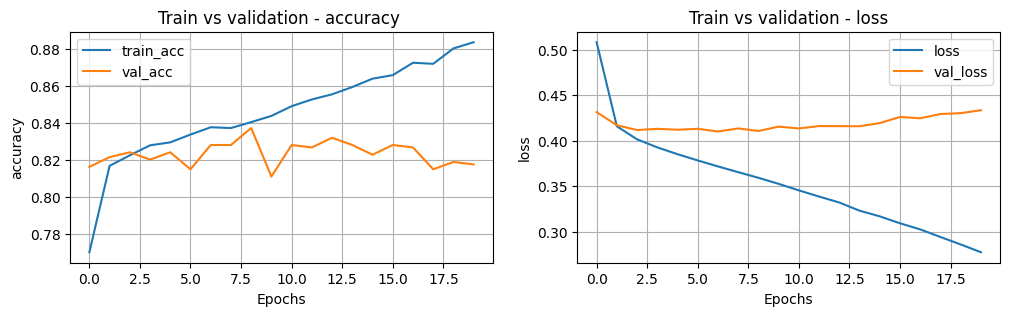

In [ ]:
plot_history(history_use)

In [ ]:
model_use.evaluate(val_sentences, val_labels)

24/24 [==============================] - 0s 10ms/step - loss: 0.4335 - accuracy: 0.8176


[0.4334666430950165, 0.817585289478302]

In [ ]:
y_pred = model_use.predict(val_sentences)
y_pred = tf.squeeze(tf.cast(tf.round(y_pred), dtype='int32'))

24/24 [==============================] - 1s 9ms/step


In [ ]:
use_10_percent_data_results = compute_metrics(val_labels, y_pred)
use_10_percent_data_results

{'accuracy': 0.8175853018372703,
 'precision': 0.817450985573112,
 'recall': 0.8175853018372703,
 'f1_score': 0.8162954533909068}

### Using Pretrained Universal Sentence Encoder - with callback functions

In [ ]:
model_use_1 = tf.keras.models.clone_model(model_use)
model_use_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 universal_sentence_encoder   (None, 512)              256797824 
 (KerasLayer)                                                    
                                                                 
 dense (Dense)               (None, 64)                32832     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 256,830,721
Trainable params: 32,897
Non-trainable params: 256,797,824
_________________________________________________________________


In [ ]:
for layer in model_use_1.layers:
    print(layer.name, layer.trainable)

universal_sentence_encoder False
dense True
dense_1 True


In [ ]:
model_use_1.compile(loss='binary_crossentropy',
                           optimizer='adam',
                           metrics=['accuracy'])

In [ ]:
# earlystopping callbacks
earlystopping_cb = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5)

## checkpoint callback
checkpoint_path = 'model_use_1.keras'
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                              save_best_only=True,
                                              monitor='val_loss')

##l lr scheduler callback
reducelr_cb = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, min_lr=1e-8)

callbacks = [checkpoint_cb, earlystopping_cb, reducelr_cb]

In [ ]:
history_use_1 = model_use_1.fit(train_sentences, train_labels,
                                              epochs=50,
                                              validation_data=(val_sentences, val_labels),
                                              callbacks=callbacks)

Epoch 1/50
215/215 [==============================] - 15s 50ms/step - loss: 0.5065 - accuracy: 0.7811 - val_loss: 0.4314 - val_accuracy: 0.8123 - lr: 0.0010
Epoch 2/50
215/215 [==============================] - 8s 35ms/step - loss: 0.4162 - accuracy: 0.8151 - val_loss: 0.4173 - val_accuracy: 0.8255 - lr: 0.0010
Epoch 3/50
215/215 [==============================] - 7s 35ms/step - loss: 0.4024 - accuracy: 0.8197 - val_loss: 0.4121 - val_accuracy: 0.8215 - lr: 0.0010
Epoch 4/50
215/215 [==============================] - 3s 12ms/step - loss: 0.3936 - accuracy: 0.8273 - val_loss: 0.4132 - val_accuracy: 0.8176 - lr: 0.0010
Epoch 5/50
215/215 [==============================] - 3s 12ms/step - loss: 0.3861 - accuracy: 0.8289 - val_loss: 0.4127 - val_accuracy: 0.8228 - lr: 0.0010
Epoch 6/50
215/215 [==============================] - 7s 35ms/step - loss: 0.3724 - accuracy: 0.8386 - val_loss: 0.4119 - val_accuracy: 0.8189 - lr: 1.0000e-04
Epoch 7/50
215/215 [==============================] - 3s 12

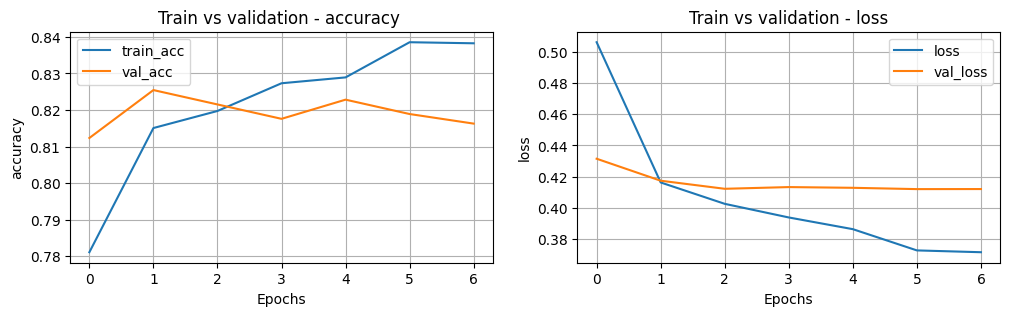

In [ ]:
plot_history(history_use_1)

In [ ]:
model_use_1.evaluate(val_sentences, val_labels)

24/24 [==============================] - 0s 11ms/step - loss: 0.4119 - accuracy: 0.8163


[0.4119313061237335, 0.8162729740142822]

In [ ]:
best_model_use_1 = tf.keras.models.load_model('/content/model_use_1.keras',
                                              custom_objects={"KerasLayer": hub.KerasLayer})

In [ ]:
best_model_use_1.evaluate(val_sentences, val_labels)

24/24 [==============================] - 1s 10ms/step - loss: 0.4119 - accuracy: 0.8189


[0.41189202666282654, 0.8188976645469666]

In [ ]:
y_pred = model_use_1.predict(val_sentences)
y_pred = tf.squeeze(tf.cast(tf.round(y_pred), dtype='int32'))

use_all_data_results = compute_metrics(val_labels, y_pred)
use_all_data_results

24/24 [==============================] - 1s 10ms/step


{'accuracy': 0.8162729658792651,
 'precision': 0.8158052570077949,
 'recall': 0.8162729658792651,
 'f1_score': 0.8153408773469076}

### USE Embedding fine tuned

In [ ]:
use_embedding_tuned = hub.KerasLayer(handle=url,
                                     trainable=True,
                                     input_shape=[],
                                     dtype=tf.string)

In [ ]:
model_use_tuned = tf.keras.Sequential([
    use_embedding_tuned,
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model_use_tuned.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 512)               256797824 
                                                                 
 dense_2 (Dense)             (None, 64)                32832     
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 256,830,721
Trainable params: 256,830,721
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model_use_tuned.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                metrics=['accuracy'])

In [ ]:
history_use_tuned = model_use_tuned.fit(train_sentences, train_labels,
                        epochs=5,
                        validation_data=(val_sentences, val_labels) )

Epoch 1/5
215/215 [==============================] - 179s 674ms/step - loss: 0.5782 - accuracy: 0.7447 - val_loss: 0.4944 - val_accuracy: 0.7940
Epoch 2/5
215/215 [==============================] - 34s 159ms/step - loss: 0.4361 - accuracy: 0.8174 - val_loss: 0.4353 - val_accuracy: 0.8163
Epoch 3/5
215/215 [==============================] - 28s 132ms/step - loss: 0.3668 - accuracy: 0.8502 - val_loss: 0.4169 - val_accuracy: 0.8058
Epoch 4/5
215/215 [==============================] - 27s 124ms/step - loss: 0.3072 - accuracy: 0.8746 - val_loss: 0.4105 - val_accuracy: 0.8110
Epoch 5/5
215/215 [==============================] - 25s 117ms/step - loss: 0.2491 - accuracy: 0.8980 - val_loss: 0.4170 - val_accuracy: 0.8228


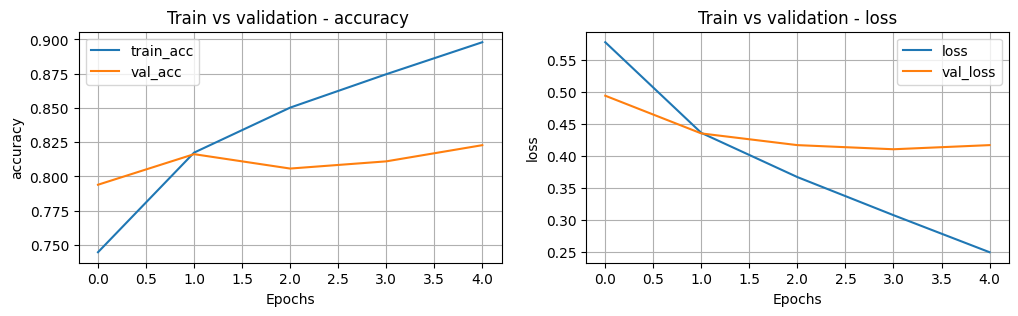

In [ ]:
plot_history(history_use_tuned)

In [ ]:
model_use_tuned.evaluate(val_sentences, val_labels)

24/24 [==============================] - 0s 10ms/step - loss: 0.4170 - accuracy: 0.8228


[0.4169503450393677, 0.8228346705436707]

In [ ]:
y_pred = model_use_tuned.predict(val_sentences)
y_pred = tf.squeeze(tf.cast(tf.round(y_pred), dtype='int32'))

24/24 [==============================] - 1s 11ms/step


In [ ]:
use_tuned_results = compute_metrics(val_labels, y_pred)
use_tuned_results

{'accuracy': 0.8228346456692913,
 'precision': 0.8223383775873557,
 'recall': 0.8228346456692913,
 'f1_score': 0.822342278840207}

### Universal Sentences Encoder Tuned with some callback functions

In [ ]:
model_use_tuned_1 = tf.keras.models.clone_model(model_use_tuned)
model_use_tuned_1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 512)               256797824 
                                                                 
 dense_2 (Dense)             (None, 64)                32832     
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 256,830,721
Trainable params: 256,830,721
Non-trainable params: 0
_________________________________________________________________


In [ ]:
for layer in model_use_tuned_1.layers:
    print(layer.name, layer.trainable)

keras_layer True
dense_2 True
dense_3 True


In [ ]:
model_use_tuned_1.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              metrics=['accuracy'])

In [ ]:
# earlystopping callbacks
earlystopping_cb = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5)

## checkpoint callback
checkpoint_path = 'model_use_tuned_1.keras'
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                              save_best_only=True,
                                              monitor='val_loss')

##l lr scheduler callback
reducelr_cb = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, min_lr=1e-8)

callbacks = [checkpoint_cb, earlystopping_cb, reducelr_cb]

In [ ]:
history_use_tuned_1 = model_use_tuned_1.fit(train_sentences, train_labels,
                                            epochs=50,
                                            validation_data=(val_sentences, val_labels),
                                            callbacks=callbacks)

Epoch 1/50
215/215 [==============================] - 241s 975ms/step - loss: 0.5756 - accuracy: 0.7381 - val_loss: 0.4791 - val_accuracy: 0.7979 - lr: 1.0000e-04
Epoch 2/50
215/215 [==============================] - 171s 799ms/step - loss: 0.4276 - accuracy: 0.8244 - val_loss: 0.4285 - val_accuracy: 0.8005 - lr: 1.0000e-04
Epoch 3/50
215/215 [==============================] - 189s 883ms/step - loss: 0.3629 - accuracy: 0.8527 - val_loss: 0.4113 - val_accuracy: 0.8202 - lr: 1.0000e-04
Epoch 4/50
215/215 [==============================] - 193s 900ms/step - loss: 0.3020 - accuracy: 0.8774 - val_loss: 0.4079 - val_accuracy: 0.8268 - lr: 1.0000e-04
Epoch 5/50
215/215 [==============================] - 25s 118ms/step - loss: 0.2363 - accuracy: 0.9061 - val_loss: 0.4210 - val_accuracy: 0.8163 - lr: 1.0000e-04
Epoch 6/50
215/215 [==============================] - 24s 113ms/step - loss: 0.1690 - accuracy: 0.9383 - val_loss: 0.4582 - val_accuracy: 0.8071 - lr: 1.0000e-04
Epoch 7/50
215/215 [====

In [ ]:
model_use_tuned_1.evaluate(val_sentences, val_labels)

24/24 [==============================] - 0s 10ms/step - loss: 0.4628 - accuracy: 0.8058


[0.4628002345561981, 0.8057742714881897]

In [ ]:
y_pred = model_use_tuned_1.predict(val_sentences)
y_pred = tf.squeeze(tf.cast(tf.round(y_pred), dtype='int32'))

use_tuned_all_data_results = compute_metrics(val_labels, y_pred)
use_tuned_all_data_results

24/24 [==============================] - 1s 10ms/step


{'accuracy': 0.8057742782152231,
 'precision': 0.8052475390386572,
 'recall': 0.8057742782152231,
 'f1_score': 0.8053698697741833}

Fine Tuning did not improve the result. One reason could be **less training data**.

I found this interesting read: **[FINE-TUNING CAN DISTORT RETRAINED FEATURES AND UNDERPERFORM  OUT-OF-DISTRIBUTION](https://openreview.net/pdf?id=UYneFzXSJWh)**


*When transferring a pretrained model to a downstream task, two popular methods are full fine-tuning (updating all the model parameters) and linear probing (updating only the last linear layer—the “head”). It is well known that fine-tuning leads to better accuracy in-distribution (ID). However, in this paper, we find that finetuning can achieve worse accuracy than linear probing out-of-distribution (OOD) when the pretrained features are good and the distribution shift is large.*

### Using the Pretrained USE as it is (no finetuning) with some additional downstream layers and tweaks

In [ ]:

url = 'https://tfhub.dev/google/universal-sentence-encoder/4'
use_embeddings = hub.KerasLayer(handle=url,
                                trainable=False,
                                input_shape=[],
                                dtype=tf.string,
                                name='universal_sentence_encoder')

In [ ]:
model = tf.keras.Sequential([
      use_embeddings,
      tf.keras.layers.Dense(128, activation='relu'),
      #tf.keras.layers.Dropout(0.5),
      tf.keras.layers.Dense(64, activation='relu'),
      tf.keras.layers.Dropout(0.5),
      tf.keras.layers.Dense(32, activation='relu'),
      tf.keras.layers.Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 universal_sentence_encoder   (None, 512)              256797824 
 (KerasLayer)                                                    
                                                                 
 dense_40 (Dense)            (None, 128)               65664     
                                                                 
 dense_41 (Dense)            (None, 64)                8256      
                                                                 
 dropout_23 (Dropout)        (None, 64)                0         
                                                                 
 dense_42 (Dense)            (None, 32)                2080      
                                                                 
 dense_43 (Dense)            (None, 1)                 33        
                                                     

In [ ]:
model.compile(loss='binary_crossentropy',
                           optimizer=tf.keras.optimizers.Adam(0.0001),
                           metrics=['accuracy'])

In [ ]:
history=model.fit(train_sentences, train_labels,
          epochs=10,
          validation_data=(val_sentences, val_labels))

Epoch 1/10
215/215 [==============================] - 6s 15ms/step - loss: 0.6783 - accuracy: 0.6259 - val_loss: 0.6421 - val_accuracy: 0.7690
Epoch 2/10
215/215 [==============================] - 3s 13ms/step - loss: 0.5731 - accuracy: 0.7622 - val_loss: 0.4895 - val_accuracy: 0.7979
Epoch 3/10
215/215 [==============================] - 4s 18ms/step - loss: 0.4691 - accuracy: 0.8032 - val_loss: 0.4427 - val_accuracy: 0.7966
Epoch 4/10
215/215 [==============================] - 3s 13ms/step - loss: 0.4407 - accuracy: 0.8114 - val_loss: 0.4292 - val_accuracy: 0.8031
Epoch 5/10
215/215 [==============================] - 3s 13ms/step - loss: 0.4216 - accuracy: 0.8184 - val_loss: 0.4214 - val_accuracy: 0.8163
Epoch 6/10
215/215 [==============================] - 3s 13ms/step - loss: 0.4129 - accuracy: 0.8231 - val_loss: 0.4156 - val_accuracy: 0.8097
Epoch 7/10
215/215 [==============================] - 4s 18ms/step - loss: 0.4047 - accuracy: 0.8273 - val_loss: 0.4125 - val_accuracy: 0.8150

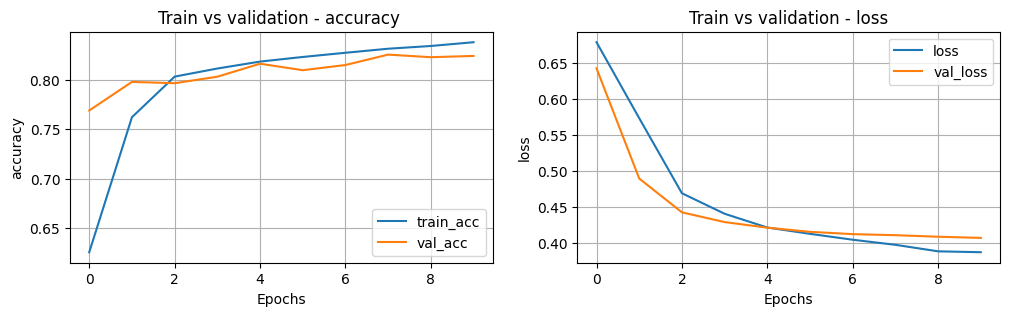

In [ ]:
plot_history(history)

This trends look much better!!

Let's try for some more epochs along with scheduled learning rate decay

In [ ]:
model_with_callbacks = tf.keras.models.clone_model(model)
model_with_callbacks.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 universal_sentence_encoder   (None, 512)              256797824 
 (KerasLayer)                                                    
                                                                 
 dense_40 (Dense)            (None, 128)               65664     
                                                                 
 dense_41 (Dense)            (None, 64)                8256      
                                                                 
 dropout_23 (Dropout)        (None, 64)                0         
                                                                 
 dense_42 (Dense)            (None, 32)                2080      
                                                                 
 dense_43 (Dense)            (None, 1)                 33        
                                                     

In [ ]:
model_with_callbacks.compile(loss='binary_crossentropy',
                           optimizer=tf.keras.optimizers.Adam(0.0001),
                           metrics=['accuracy'])

In [ ]:
# earlystopping callbacks
earlystopping_cb = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5)

## checkpoint callback
checkpoint_path = 'model.keras'
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                              save_best_only=True,
                                              monitor='val_loss')

##l lr scheduler callback
reducelr_cb = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-8)

callbacks = [reducelr_cb, checkpoint_cb, earlystopping_cb]

In [ ]:
history=model_with_callbacks.fit(train_sentences, train_labels,
                                 epochs=100,
                                 validation_data=(val_sentences, val_labels),
                                 callbacks=callbacks)

Epoch 1/100
215/215 [==============================] - 97s 439ms/step - loss: 0.3891 - accuracy: 0.8364 - val_loss: 0.4062 - val_accuracy: 0.8255 - lr: 1.0000e-04
Epoch 2/100
215/215 [==============================] - 96s 448ms/step - loss: 0.3806 - accuracy: 0.8413 - val_loss: 0.4048 - val_accuracy: 0.8255 - lr: 1.0000e-04
Epoch 3/100
215/215 [==============================] - 3s 14ms/step - loss: 0.3751 - accuracy: 0.8440 - val_loss: 0.4050 - val_accuracy: 0.8294 - lr: 1.0000e-04
Epoch 4/100
215/215 [==============================] - 88s 412ms/step - loss: 0.3738 - accuracy: 0.8472 - val_loss: 0.4047 - val_accuracy: 0.8294 - lr: 1.0000e-04
Epoch 5/100
215/215 [==============================] - 3s 15ms/step - loss: 0.3651 - accuracy: 0.8495 - val_loss: 0.4050 - val_accuracy: 0.8386 - lr: 1.0000e-04
Epoch 6/100
215/215 [==============================] - 88s 413ms/step - loss: 0.3639 - accuracy: 0.8514 - val_loss: 0.4044 - val_accuracy: 0.8241 - lr: 1.0000e-04
Epoch 7/100
215/215 [=====

In [ ]:
model_with_callbacks.evaluate(val_sentences, val_labels)

24/24 [==============================] - 0s 12ms/step - loss: 0.4075 - accuracy: 0.8307


[0.40750887989997864, 0.8307086825370789]

In [ ]:
best_model = tf.keras.models.load_model('/content/model.keras',
                                              custom_objects={"KerasLayer": hub.KerasLayer})

In [ ]:
best_model.evaluate(val_sentences, val_labels)

24/24 [==============================] - 1s 11ms/step - loss: 0.4044 - accuracy: 0.8241


[0.40439650416374207, 0.8241469860076904]

In [ ]:
y_pred = model_with_callbacks.predict(val_sentences)
y_pred = tf.squeeze(tf.cast(tf.round(y_pred), dtype='int32'))

model_results = compute_metrics(val_labels, y_pred)
model_results

24/24 [==============================] - 1s 10ms/step


{'accuracy': 0.8307086614173228,
 'precision': 0.8320390239681579,
 'recall': 0.8307086614173228,
 'f1_score': 0.8288567252530202}

In [ ]:
model_with_callbacks.save('use_pretrained_model')

In [ ]:
!cp -r '/content/use_pretrained_model' '/content/drive/MyDrive/small_projects'

load the saved model

In [4]:
import tensorflow_hub as hub
loaded_model =  tf.keras.models.load_model('/content/drive/MyDrive/small_projects/use_pretrained_model',
                                              custom_objects={"KerasLayer": hub.KerasLayer})

In [33]:
loaded_model.evaluate(val_sentences, val_labels)

24/24 [==============================] - 2s 14ms/step - loss: 0.4075 - accuracy: 0.8307


[0.40750887989997864, 0.8307086825370789]

### TO-DO: Train the last model on all training data

In [ ]:
train_all_sentences = train_df_shuffled['text'].to_numpy()
train_all_labels = train_df_shuffled['target'].to_numpy()

## Model Evaluation

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

In [ ]:
y_true=val_labels

In [ ]:
accuracy_score(y_true, y_pred)

0.8307086614173228

Looking at the confusion matrix

In [ ]:
# compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

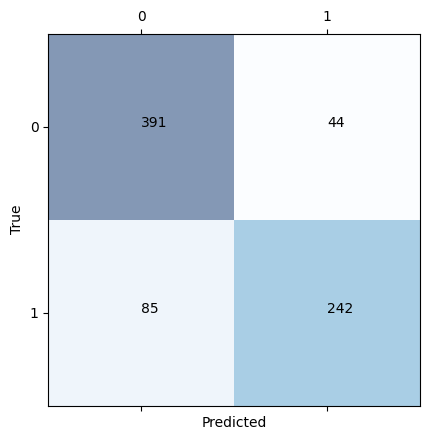

In [ ]:
plt.matshow(cm, cmap='Blues', alpha=0.5)
plt.xlabel('Predicted')
plt.ylabel('True')
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j])

## Pedicting the test tweets

In [ ]:
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [ ]:
test_df.shape

(3263, 4)

In [ ]:
test_sentences = test_df['text'].to_numpy()
test_sentences.shape

(3263,)

In [ ]:
test_preds = model_with_callbacks.predict(test_sentences)
test_preds = tf.squeeze(tf.cast(tf.round(test_preds), dtype='int32'))

102/102 [==============================] - 2s 11ms/step


In [ ]:
test_preds.shape

TensorShape([3263])

In [ ]:
test_pred_df = pd.DataFrame({'id':test_df['id'], 'target':test_preds})
test_pred_df.to_csv('sample_submission.csv', index=False)

Submitted the file to https://www.kaggle.com/competitions/nlp-getting-started/leaderboard

On leaderboard, the model scored: 0.81489

That's it!!!

In [ ]:
## End Note
print("So, whether you eat or drink or whatever you do, you should do it all for God's glory. 1 Corinthians 10:31")